In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS
**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con ansiedad o es de control.


**control**:     0

**ansiedad**:   1

#DATOS DE PRUEBA

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32528 non-null  object 
 1   TWEET_ID    32528 non-null  float64
 2   TWEET_TEXT  64987 non-null  object 
 3   trastorno   64985 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"3522.0, intenta combatir siéntete indeseable c...",1.0
1,302.0,2.147484e+09,"RT @giraltpablo: Lamentablemente, Ecuador perd...",0.0
2,NaN,NaN,Minitrigos helados ansiosos.,1.0
3,NaN,NaN,Está bien. Yo he estado ahí antes. Dudaba de m...,1.0
4,NaN,NaN,¡Siento escuchar eso! Considere la posibilidad...,1.0
5,480.0,2.147484e+09,"No entiendo eso de apoyar en una final,al equi...",0.0
6,266.0,2.147484e+09,"""Come On"" - @akapellah feat @BigSotoLuc &amp; ...",0.0
7,NaN,NaN,",Hola, chico, aparentemente tiene una enfermed...",1.0
8,390.0,2.147484e+09,"RT @excelentum: El que domina su cólera, domin...",0.0
9,288.0,2.147484e+09,RT @Guillodibujante: https://t.co/YO0oAArJJq,0.0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null_values)

Número de filas nulas o vacías en la columna 'trastorno': 4


In [ ]:
# Eliminar filas con valores nulos en la columna 'trastorno'
data_train = data_train.dropna(subset=['trastorno'])

# Verificar si hay filas nulas o vacías en la columna 'trastorno' después de eliminarlas
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno' después de eliminarlas:", null_values)

Número de filas nulas o vacías en la columna 'trastorno' después de eliminarlas: 0


In [ ]:
data_train['trastorno'] = data_train['trastorno'].astype('int64')
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64985 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32524 non-null  object 
 1   TWEET_ID    32524 non-null  float64
 2   TWEET_TEXT  64985 non-null  object 
 3   trastorno   64985 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,"3522.0, intenta combatir siéntete indeseable c...",1
1,302.0,2.147484e+09,"RT @giraltpablo: Lamentablemente, Ecuador perd...",0
2,NaN,NaN,Minitrigos helados ansiosos.,1
3,NaN,NaN,Está bien. Yo he estado ahí antes. Dudaba de m...,1
4,NaN,NaN,¡Siento escuchar eso! Considere la posibilidad...,1
5,480.0,2.147484e+09,"No entiendo eso de apoyar en una final,al equi...",0
6,266.0,2.147484e+09,"""Come On"" - @akapellah feat @BigSotoLuc &amp; ...",0
7,NaN,NaN,",Hola, chico, aparentemente tiene una enfermed...",1
8,390.0,2.147484e+09,"RT @excelentum: El que domina su cólera, domin...",0
9,288.0,2.147484e+09,RT @Guillodibujante: https://t.co/YO0oAArJJq,0


#Preprocesamiento de los datos

In [ ]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_es = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Eliminar etiquetas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpieza del texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
        # Tokenizar el texto en palabras
        words = text.split()

        # Eliminar palabras vacías
        words = [word for word in words if word not in stopwords_es]

        # Reconstruir el texto limpio
        text = ' '.join(words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

*lematizar y extraer términos*

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64985 entries, 0 to 64988
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     32524 non-null  object 
 1   TWEET_ID    32524 non-null  float64
 2   TWEET_TEXT  64985 non-null  object 
 3   trastorno   64985 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,NaN,NaN,intentar combatir siéntete indeseable perfecci...,1
1,302.0,2.147484e+09,perder carta ganador localía allí escapar posi...,0
2,NaN,NaN,helado ansioso,1
3,NaN,NaN,bien ahí amigo amor saber decir intentar dar y...,1
4,NaN,NaN,escuchar posibilidad utilizar aceite esencial ...,1
5,480.0,2.147484e+09,entender apoyar finalal equipo elimino compent...,0
6,266.0,2.147484e+09,feat amp,0
7,NaN,NaN,chico aparentemente enfermedad terminal decir ...,1
8,390.0,2.147484e+09,dominar cólero dominar peor enemigo,0
9,288.0,2.147484e+09,,0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 1846


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


#Vectorización de los datos
LDA no trabaja directamente con los documentos de texto, sino que utiliza también una representación _Bag of Words_. En concreto, se ha de crear una matriz en la que el elemento en la posición $(d,t)$ representa el número de veces que aparece el término $t$ en el documento $d$


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 200
umbral = 20
count_vect = CountVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)

# Aplicar el CountVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz BoW
bow_train = count_vect.fit_transform(data_train['TWEET_TEXT'].values)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es:", len(count_vect.vocabulary_))

# Crear arrays X y y para los datos y etiquetas respectivamente
X = bow_train  # Matriz BoW
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'
# Obtener índices de filas no nulas en X

El tamaño del vocabulario es: 3362


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicar LDA para reducir la dimensionalidad
n_topics = 10  # Define el número de tópicos (componentes)
lda = LDA(n_components=n_topics)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [ ]:


# Crear un modelo de bosque aleatorio
model = RandomForestClassifier(
    n_estimators=300,  # Numero de árboles
    max_depth=100,     # Profundidad máxima
    random_state=42    # Selección de la semilla de manera aleatoria
)

# Entrenar el modelo en los datos de entrenamiento transformados por LDA
model.fit(X_train_lda, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = model.predict(X_test_lda)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy * 100:.2f}%")

# Calcular la precisión, recall y puntuación F1
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precisión: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")


Exactitud del modelo: 87.34%
Precisión: 87.43%
Recall: 87.34%
Puntuación F1: 87.33%


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[8275  980]
 [1419 8268]] 

Proporción de comentarios positivos: 0.51
Proporción de comentarios positivos etiquetados: 0.49


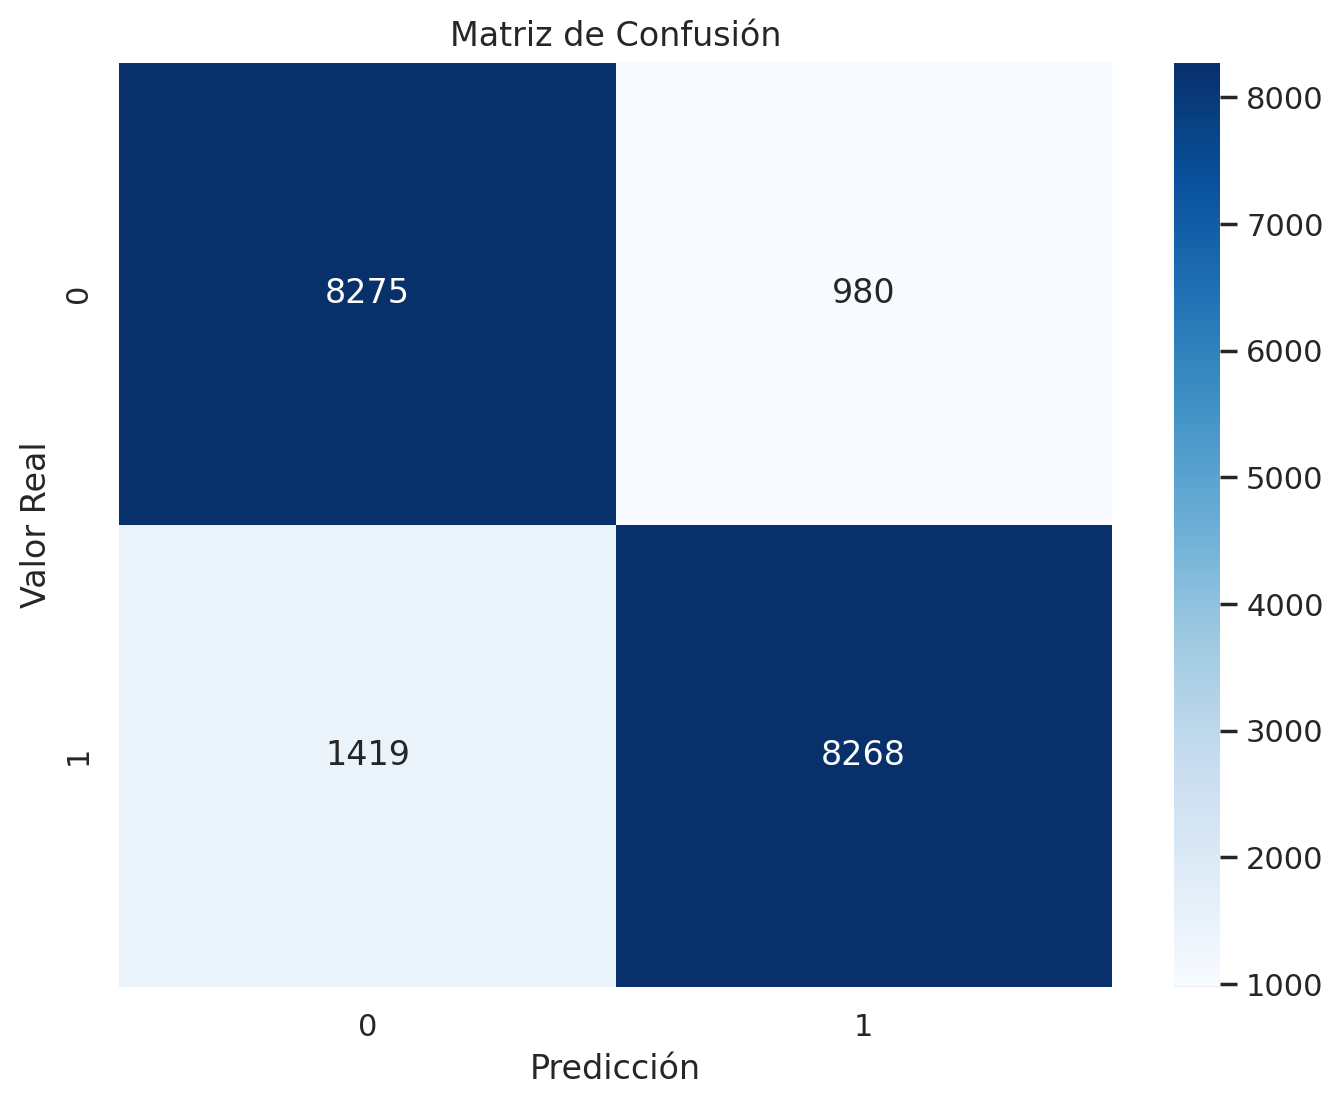

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Aprensizaje del modelo: Bosque aleatorio
**Validación Cruzada K=10**

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Inicializar listas para almacenar métricas
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Crear un objeto StratifiedKFold para dividir los datos en k-folds estratificados
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dividir los datos en k-folds y realizar la validación cruzada
for train_index, val_index in skf.split(X_train_lda, y_train):
    X_train_fold, X_val_fold = X_train_lda[train_index], X_train_lda[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Crear un modelo de Random Forest
    model = RandomForestClassifier(
        n_estimators=300,  # Número de árboles
        max_depth=100,     # Profundidad máxima
        random_state=42    # Selección de la semilla de manera aleatoria
    )

    # Entrenar el modelo en los datos de entrenamiento transformados por LDA
    model.fit(X_train_fold, y_train_fold)

    # Predecir las etiquetas en el conjunto de entrenamiento y validación
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)

    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_precision = precision_score(y_train_fold, y_train_pred, average='weighted')
    train_recall = recall_score(y_train_fold, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train_fold, y_train_pred, average='weighted')

    # Calcular métricas de validación
    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    val_precision = precision_score(y_val_fold, y_val_pred, average='weighted')
    val_recall = recall_score(y_val_fold, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

    # Almacenar las métricas en las listas
    train_accuracy_scores.append(train_accuracy)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)
    train_f1_scores.append(train_f1)

    val_accuracy_scores.append(val_accuracy)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    val_f1_scores.append(val_f1)

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas promediadas
print("Métricas de entrenamiento promediadas:")
print(f"Exactitud: {train_accuracy_mean * 100:.2f}%")
print(f"Precisión: {train_precision_mean * 100:.2f}%")
print(f"Recuperación: {train_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {train_f1_mean * 100:.2f}%")

print("\nMétricas de validación promediadas:")
print(f"Exactitud: {val_accuracy_mean * 100:.2f}%")
print(f"Precisión: {val_precision_mean * 100:.2f}%")
print(f"Recuperación: {val_recall_mean * 100:.2f}%")
print(f"Puntuación F1: {val_f1_mean * 100:.2f}%")



Métricas de entrenamiento promediadas:
Exactitud: 99.50%
Precisión: 99.51%
Recuperación: 99.50%
Puntuación F1: 99.50%

Métricas de validación promediadas:
Exactitud: 86.89%
Precisión: 86.98%
Recuperación: 86.89%
Puntuación F1: 86.89%


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_lda)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_test, y_pred_binario)
prop_real = np.sum(y_test)/len(y_test)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_test)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[8268  987]
 [1423 8264]] 

Proporción de comentarios positivos: 0.51
Proporción de comentarios positivos etiquetados: 0.49


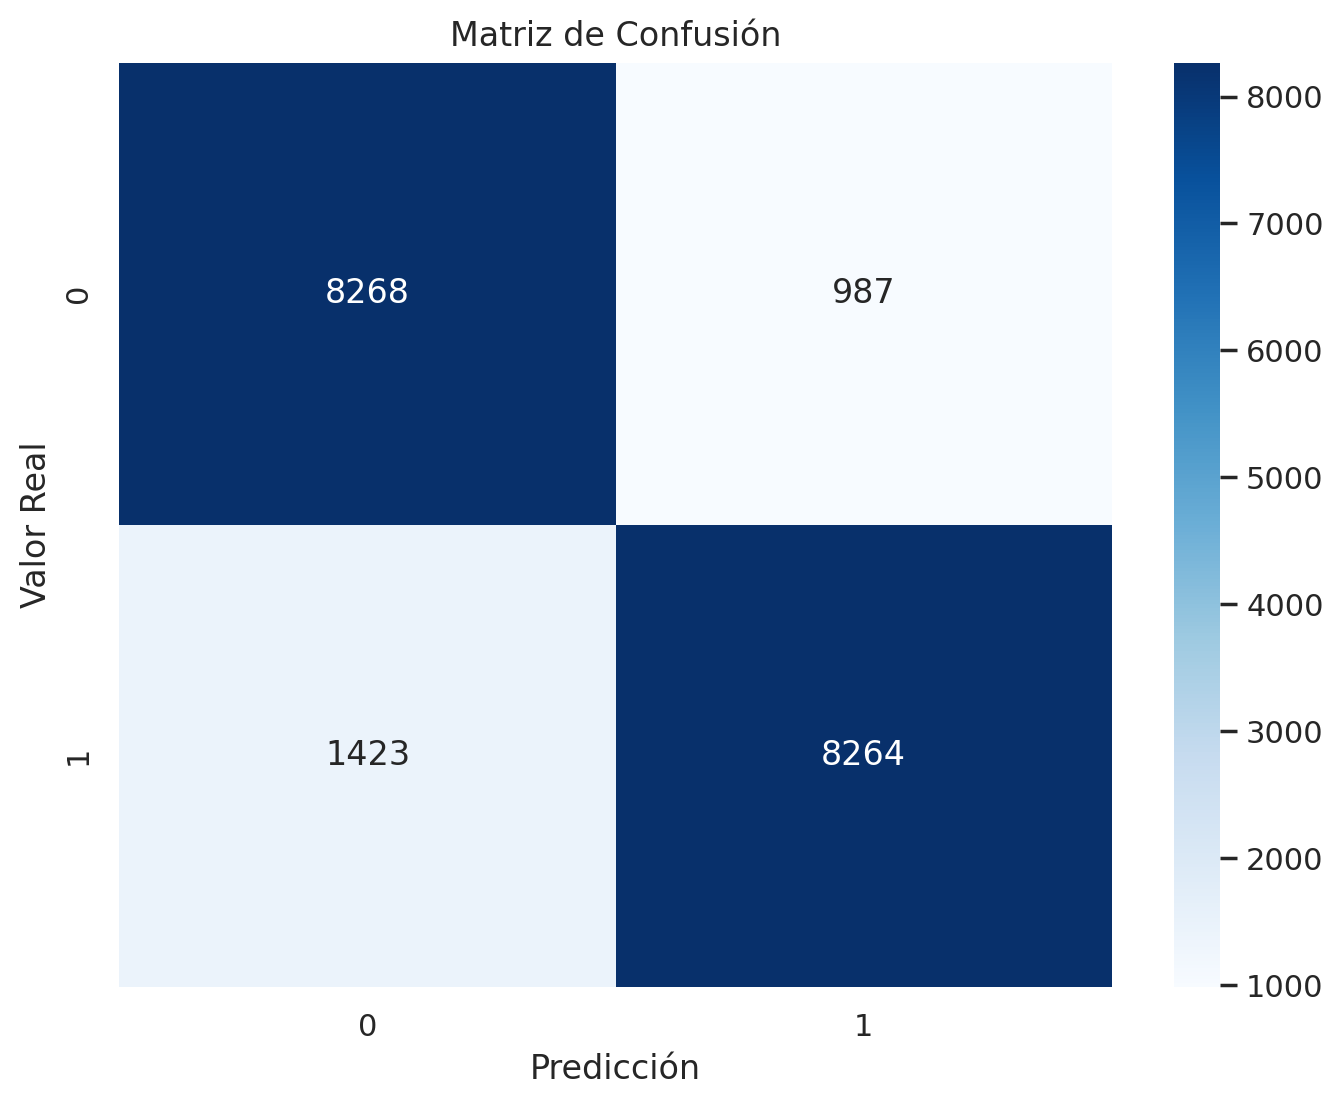

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

# Guardar el modelo


In [ ]:
import joblib
import os
# Guardar el modelo entrenado
model_folder = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)'  # Ruta de la carpeta donde deseas guardar el modelo
model_filename = 'TWEETS_ansiedad_BoW_RF_LDA.pkl'
model_path = os.path.join(model_folder, model_filename)

# Asegurarse de que la carpeta exista
os.makedirs(model_folder, exist_ok=True)

# Guardar el modelo utilizando joblib
joblib.dump(model, model_path)

# Imprimir la ruta del modelo guardado
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs ansiedad)/TWEETS_ansiedad_BoW_RF_LDA.pkl
